# Binary Classification of the "Don't Patronize Me!" Dataset

Perform Binary Classification to predict whether a text contains patronizing and condescending language. The task was task 4 (subtask 1) in the SemEval 2022 competition.

## Initialize Environment

In [1]:
# Library imports
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt    

from nltk import PorterStemmer, WordNetLemmatizer
import codecs

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from tqdm import tqdm
import torch.nn as nn

import re
from functools import partial

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

# Pre-trained models
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel
from transformers.models.bert.modeling_bert import BertOnlyMLMHead
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler


def fix_seed(seed=420.69):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
#   np.random.seed(seed)
#   random.seed(seed)

fix_seed()

data_path = '../bin/data'
embeddings_path = '../bin/word_embeddings'


/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not torch.cuda.is_available():
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda:0'

print(DEVICE)

cuda:0


In [3]:
h_params = {
    'model': 'None'
    , 'batch_size': 8
    , 'embedding_dimensions': 50
}

## Raw Data

### Loading

Load the data into pandas dataframes

In [4]:
# Import Data
train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'
test_data_path  = f'{data_path}/task4_test.tsv'

train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])
test_data  = pd.read_csv(test_data_path,  delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text'])

train_data = train_data.drop(['art_id'], axis=1)
test_data = test_data.drop(['art_id'], axis=1)

In [5]:
# Concatenate label information to train data
dev_label_path   = f'{data_path}/dev_semeval_parids-labels.csv'
train_label_path = f'{data_path}/train_semeval_parids-labels.csv'

dev_label   = pd.read_csv(dev_label_path, delimiter=',')
train_label = pd.read_csv(train_label_path, delimiter=',')

detailed_labels = pd.concat([dev_label, train_label], ignore_index=True, join='inner', names=['simple', 'detailed'])
train_data = pd.merge(train_data, detailed_labels, on='par_id')
train_data = train_data.rename(columns={'label_x': 'label', 'label_y': 'label_detailed'})

In [6]:
# Add Binary Classification column for ease of checking
train_data.loc[:, 'is_patronizing'] = 0
train_data.loc[train_data['label'].isin([2,3,4]), 'is_patronizing'] = 1

In [7]:
train_data = train_data.dropna(subset = 'text')
test_data = test_data.dropna(subset = 'text')

In [8]:
keyword_set = sorted(set(train_data['keyword']))
country_set = sorted(set(train_data['country_code']))

def keyword_to_id(country:str, keyword_set=keyword_set):
    return keyword_set.index(country)

def id_to_keyword(id:int, keyword_set=keyword_set):
    assert id >= 0
    assert id < len(keyword_set)
    return keyword_set[id]

def country_to_id(country:str, country_set=country_set):
    return country_set.index(country)

def id_to_country(id:int, country_set=country_set):
    assert id >= 0
    assert id < len(country_set)
    return country_set[id]

## Pre-processing

### Masking

In [9]:
# Randomly masking tokens in a sentence as a pre-processing step
def mask_tokens(inputs, tokenizer, mlm_probability):
    """Given a tokenized input, will prepare masked tokens inputs/labels for Masked Language Modelling. 'We want to train BERT to predict an mlm_probability% of tokens (in the original paper it is 15%) of which 80% will be replaced by a ``[MASK]`` token, 10% with a random token and 10% remain the same token.' (from tutorial)"""

    assert tokenizer.mask_token is not None and "Tokenizer should not be none. (how can we mask if we don't know what to call it!)"

    labels = inputs.clone()

    # We sample a few tokens in each sequence for masked-LM training (with probability mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)

    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

### LEGACY: Remove Stop Words

explanation: https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
we don't always remove stop words, e.g. https://www.ibm.com/docs/en/watson-explorer/11.0.0?topic=analytics-stop-word-removal when a sentence consists only of stop words, but this library takes care of it

"Surprisingly, the stopwords received as much attention as non-stop words, but removing them has no effect inMRR performances." https://stackoverflow.com/questions/63633534/is-it-necessary-to-do-stopwords-removal-stemming-lemmatization-for-text-classif

In [10]:
from gensim.parsing.preprocessing import remove_stopwords

# Another sample text
new_text = "I do not like you because I'm better than you"
 
# Remove stopwords using Gensim
new_filtered_text = remove_stopwords(new_text)
 
print("Original Text:", new_text)
print("Text after Stopword Removal:", new_filtered_text)

Original Text: I do not like you because I'm better than you
Text after Stopword Removal: I like I'm better


### Data Formatting

In [11]:
# Creating Datasets for formatting entries from the PCL dataset.
class LabelledDataset(Dataset):
    def __init__(self, data_frame: pd.DataFrame):
        self.data = data_frame

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Returns a singular item with all pre-processing required for the tester"""

        data = {'keyword'     : self.data['keyword'].iloc[idx],
                'country_code': self.data['country_code'].iloc[idx],
                'text'        : self.data['text'].iloc[idx]}
        
        # instead of label and label_detailed we use is_patronizing
        label = {'is_patronizing': self.data['is_patronizing'].iloc[idx]}

        return data, label
    
class WithheldDataset(Dataset):
    def __init__(self, data_frame: pd.DataFrame):
        self.data = data_frame
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = {'keyword'     : self.data['keyword'].iloc[idx],
                'country_code': self.data['country_code'].iloc[idx],
                'text'        : self.data['text'].iloc[idx]}
        
        return data

In [12]:
# atm, collate_fn is shared between the two functions, therefore, we keep it separate and feed it as input to both functions when we define the DataLoader
def collate_fn(batch, tokenizer, withheld, trunc_len = 300, mask = False, mlm_probability = 0.15):
    """merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style"""

    encodings = []

    assert not withheld or not mask and "We cannot mask test or validation data"

    if not withheld:
        input_features = [i for i, _ in batch]
        output_labels  = [o for _, o in batch]    
    else:
        input_features = batch

    # 1. We pad shorter sentences to a length of trunc_len tokens since the maximum sequence size for BERT is 512
    batched_text = [item['text'] for item in input_features]
    encodings    = tokenizer(batched_text, return_tensors='pt', padding=True, truncation=True, max_length=trunc_len)

    ## 1.1 Optionally, mask some entries of the tokenized input
    if mask:
        masked_input, labels = mask_tokens(encodings['input_ids'], tokenizer, mlm_probability)
        encodings['input_ids'] = masked_input
        encodings['labels'] = labels

    # 2. We encode the keywords in the sorted order that they appear in the text. We know the set of words from the pre-requisites.
    batched_keywords      = list(map(lambda item: keyword_to_id(item['keyword']), input_features))
    encodings['keywords'] =  torch.tensor(batched_keywords)

    # 3. We similarly do the above for the countries to get an index encoding of the country
    batched_country_codes     = list(map(lambda item: country_to_id(item['country_code']), input_features))
    encodings['country_code'] =  torch.tensor(batched_country_codes)

    if withheld:
        return encodings
    else:
        # As a final task we also process the output labels into a tensor
        encodings['labels'] = torch.tensor([item['is_patronizing'] for item in output_labels])
        return encodings

## Data Splits

split the data whilst keeping distributions of country, text and is_patronizing counts even

In [13]:
def pie_data_distributions(pie_series, pie_series_label):
    """Plots some pie charts for data distribution (Assume len(pie_series) inputs)

    Args:
        pie_series (_type_): pandas series 
        pie_series_label (_type_): for the title
    """

    assert len(pie_series) == len(pie_series_label) and "expected inputs of same length"

    _, axs = plt.subplots(1, len(pie_series), figsize=(len(pie_series)*5, 5))

    for idx, (series, title) in enumerate(zip(pie_series, pie_series_label)):
        tmp = series.value_counts()

        wedges, _, _ = axs[idx].pie(tmp, labels=tmp.index, autopct='%1.1f%%', startangle=90)
        legend_labels = [f'{label} ({count})' for label, count in zip(tmp.index, tmp)]
        axs[idx].legend(wedges, legend_labels, title="Class 1 and 0", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        axs[idx].set_title(f'Distribution for {title}')

    plt.tight_layout()
    plt.show()

In [14]:
def generate_data_splits(train_data):
    # The stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. 

    X_train, X_val, y_train, y_val = train_test_split(train_data[['text', 'keyword', 'country_code']]
                                                    , train_data['is_patronizing']
                                                    , train_size=0.8
                                                    , test_size=0.2
                                                    , random_state=0
                                                    , stratify=train_data[['is_patronizing']]
                                                    )
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape : {X_val.shape}")
    print(f"y_test shape : {y_val.shape}")
    print()
    print("=== DISTRIBUTION FOR TRAINING DATA ===")
    pie_data_distributions(
        [X_train['country_code'], X_train['keyword'], y_train],
        ['train country_code label', 'train keyword label', 'train binary classification']
    )

    print("=== DISTRIBUTION FOR VALIDATION DATA ===")
    pie_data_distributions(
        [X_val['country_code'], X_val['keyword'], y_val],
        ['validation country_code label', 'validation keyword label', 'validation binary classification']
    )

    print("=== DISTRIBUTION FOR TEST DATA ===")
    pie_data_distributions(
        [test_data['country_code'], test_data['keyword']],
        ['test country_code label', 'test keyword label']
    )

    return X_train, X_val, y_train, y_val

### Distribution before Minority oversampling and Majority Undersampling

X_train shape: (8374, 3)
y_train shape: (8374,)
X_test shape : (2094, 3)
y_test shape : (2094,)

=== DISTRIBUTION FOR TRAINING DATA ===


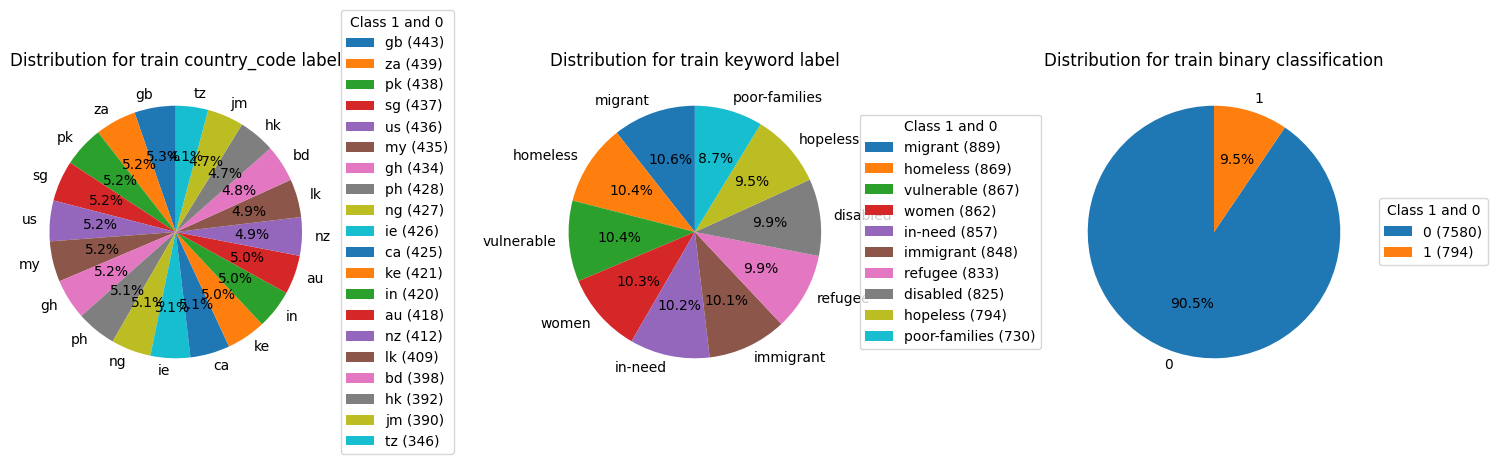

=== DISTRIBUTION FOR VALIDATION DATA ===


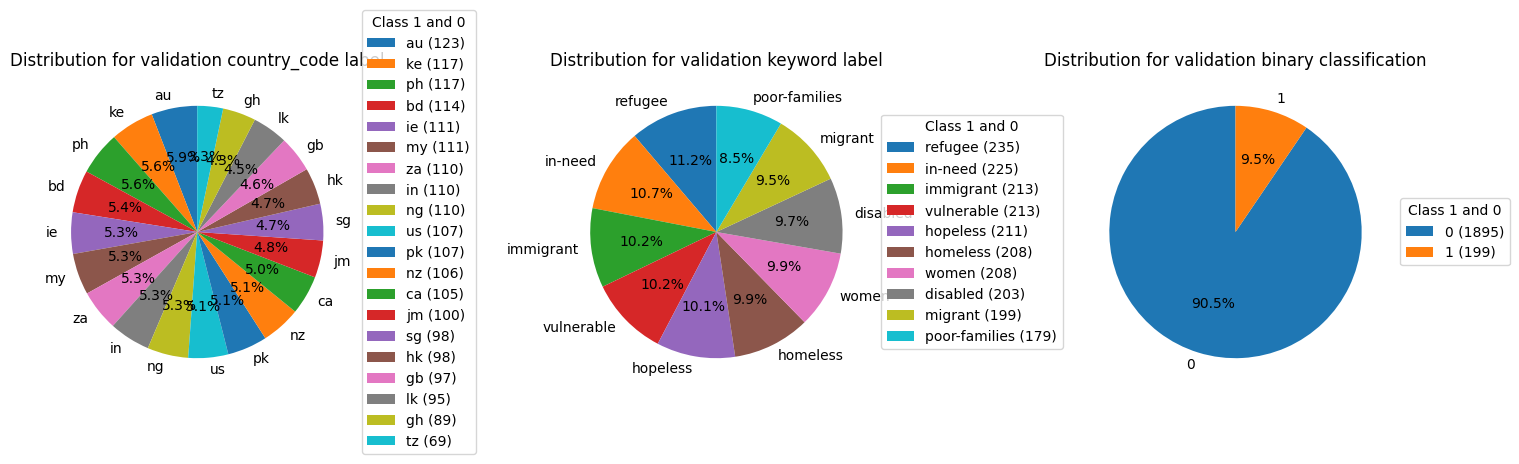

=== DISTRIBUTION FOR TEST DATA ===


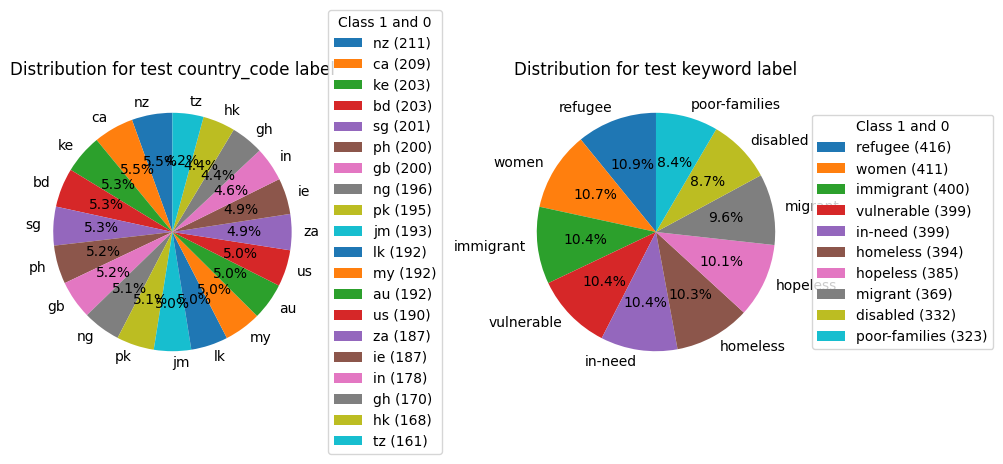

In [15]:
X_train, X_val, y_train, y_val = generate_data_splits(train_data)

### Up-sample the Minority Class

(Initially) Inspired by https://datascience.stackexchange.com/questions/27671/how-do-you-apply-smote-on-text-classification 

Code implemented from https://arxiv.org/pdf/1901.11196.pdf

In [16]:
!git clone https://github.com/jasonwei20/eda_nlp.git
from eda_nlp.code.eda import *

fatal: destination path 'eda_nlp' already exists and is not an empty directory.


In [17]:
# Default parameters have shown good performance in the original paper
eda("I hate you because I think that I'm better than you", alpha_ri=0.0, num_aug=5)

['i hatred you because i think that im better than you',
 'hate because i think that im better than you',
 'i because you hate i think that im better than you',
 'i hate you because i think that im better than you',
 'i hate you because i think that im practiced than you',
 'i hate you because i think that im better than you']

In [18]:
num_aug = 5

eda_upsampled = train_data[train_data['is_patronizing'] == 1]
eda_upsampled.loc[:, 'text'] = eda_upsampled.apply(lambda row: eda(row['text'], alpha_ri=0.0, num_aug=num_aug), axis=1)

upsampled_positives = pd.DataFrame(columns=train_data.columns)

for _, row in eda_upsampled.iterrows():
    for upsample in row['text']:
        # insert into upsampled_positives the row['text'] and the remaining columns in variable row
        new_row = pd.DataFrame([row], columns=train_data.columns)
        new_row['text'] = upsample
        upsampled_positives = pd.concat([upsampled_positives, new_row], ignore_index=True)

train_data_minority_upsampled = pd.concat([upsampled_positives, train_data[train_data['is_patronizing'] == 0]], ignore_index=True)

X_train shape: (12346, 3)
y_train shape: (12346,)
X_test shape : (3087, 3)
y_test shape : (3087,)

=== DISTRIBUTION FOR TRAINING DATA ===


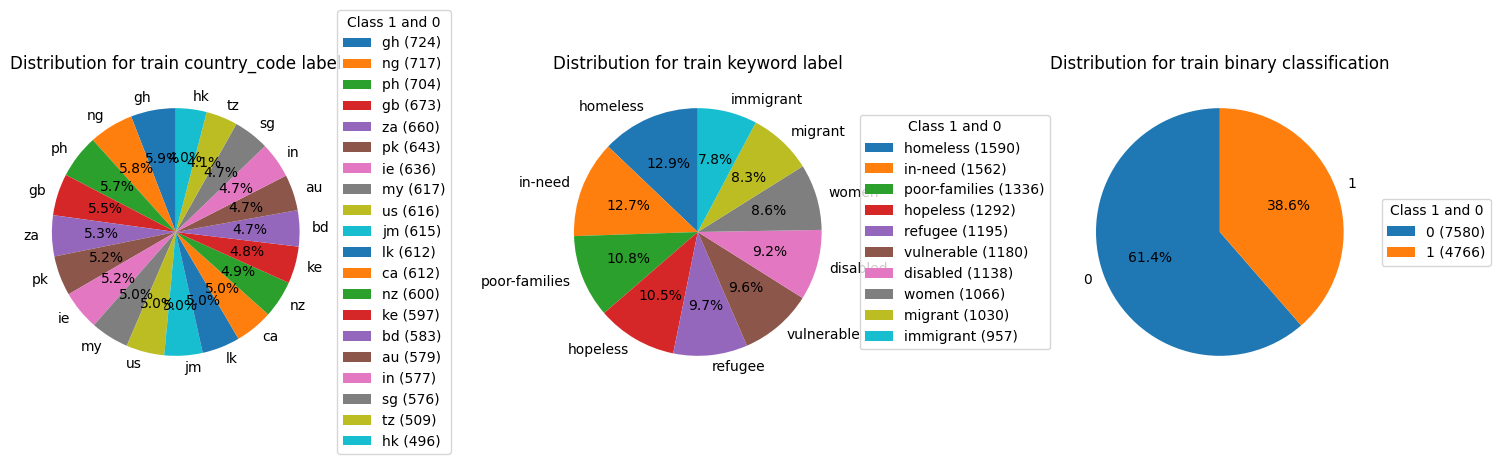

=== DISTRIBUTION FOR VALIDATION DATA ===


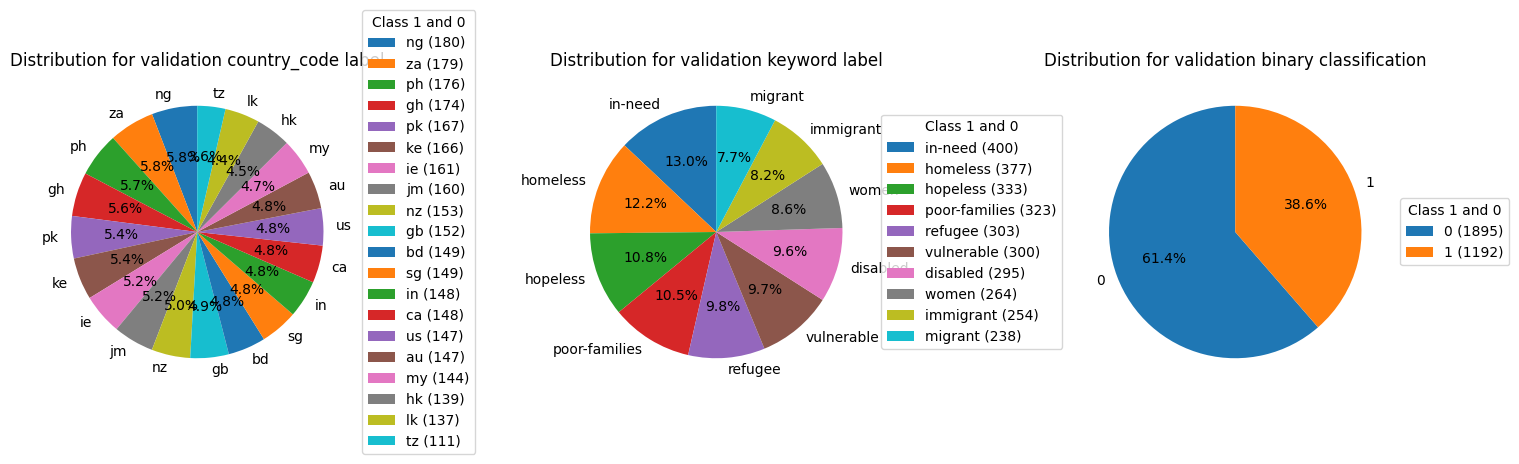

=== DISTRIBUTION FOR TEST DATA ===


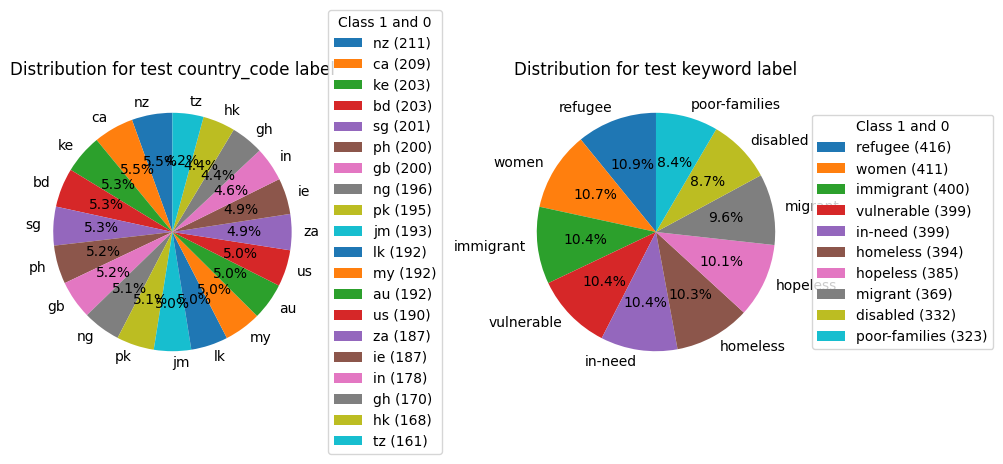

In [19]:
X_train, X_val, y_train, y_val = generate_data_splits(train_data_minority_upsampled)

In [20]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# bert was trained on unpublished books, might be better to train on social media where typos are more common?

# Set up DataLoaders for test, validation and training
sampled_train_data = pd.merge(X_train, y_train, left_index=True, right_index=True)
sampled_val_data = pd.merge(X_val, y_val, left_index=True, right_index=True)

train_loader = DataLoader(dataset=LabelledDataset(train_data)
                          , batch_size=16
                          , shuffle=True
                          , collate_fn=partial(collate_fn, withheld=False, mask=False, tokenizer=tokenizer))

## The validation and training don't require masking (we're evaluating the performance of the model, not training to train it against masked entries)
val_loader = DataLoader(dataset=LabelledDataset(sampled_val_data)
                        , batch_size=16
                        , shuffle=True
                        , collate_fn=partial(collate_fn, withheld=False, tokenizer=tokenizer))

test_loader = DataLoader(dataset=WithheldDataset(sampled_train_data)
                         , batch_size=16
                         , shuffle=True
                         , collate_fn=partial(collate_fn, withheld=True, tokenizer=tokenizer))

In [21]:
%%script false --no-raise-error
# don't execute this cell whilst running final submission

for batch in test_loader:
  # Print the labels we received
  for key, value in batch.items():
    print(f'{key}, {value.numpy().tolist()}')
  
  # Don't print for the other batches... (we get the idea)
  break

In [22]:
%%script false --no-raise-error
# don't execute this cell whilst running final submission

for batch in train_loader:
    # # Print the labels we received
    # for key, value in x.items():
    #     print(f'{key}, {value.numpy().tolist()}')
    
    # # Don't print for the other batches... (we get the idea)
    # break   
    break

{str(k): str(v.shape) for k, v in batch.items()}

## Evaluation

In [23]:
def performance_metrics(model, dataloader):
    """Given a model's predicted output, and its corresponding expected output, generates performance metrics and confusion matrix"""

    predicted = []
    expected = []

    with tqdm(dataloader, unit="batch") as tepoch:
        for batch_idx, batch in enumerate(tepoch):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            with torch.no_grad():
                batch = {k: batch[k] for k in batch.keys() if k not in ('keywords','country_code')}
                outputs = model(**batch)

            logits = outputs.logits
            predicted.append(torch.argmax(logits, dim=-1))
            expected.append(batch['labels'])
    
    predicted = torch.cat(predicted).cpu().numpy()
    expected = torch.cat(expected).cpu().numpy()

    print(classification_report(expected, predicted))

    set(predicted)
    cm = confusion_matrix(expected, predicted, labels=[0, 1]) 

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True));  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

    ax.set_title('Confusion Matrix')

    ax.xaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])
    ax.yaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])

In [24]:
def model_prediction(model):
    """Given a model and input for the forward pass, will output pretty-printed output"""
    # Get one random sample from the test data
    random_index = X_val.sample(n=1).index.values[0]

    while random_index not in train_data.index:
        random_index = X_val.sample(n=1).index.values[0]

    # Extract random sample
    tdf = train_data.loc[[random_index]][['text', 'is_patronizing']]
    test_paragraph, real_label = tdf['text'].values[0], tdf['is_patronizing'].values[0]

    # Get model prediction
    predicted_label, _ = model.predict([tdf['text'].values[0]])

    print(f"=== Paragraph example ===\n{test_paragraph.capitalize()}")
    print(f"\tReal Label:      {real_label}")
    print(f"\tModel Prediction:{predicted_label[0]}")


## Model

In [25]:
def train_model(model, optimizer, train_loader=train_loader, accelerator=None, h_params=h_params):

    num_epochs = 1
    num_training_steps = num_epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    progress_bar = tqdm(range(num_training_steps))

    loss_tracking = []

    model.train()
    for _ in range(num_epochs):
        for i, batch in enumerate(train_loader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}

            batch = {k: batch[k] for k in batch.keys() if k not in ('keywords','country_code')}

            outputs = model(**batch)
            loss = outputs.loss

            if accelerator is not None:
                accelerator.backward(loss)
            else:
                loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

            if i % 20 == 0:
                loss_tracking.append(loss)

            if i % 100 == 0:
                print(f'loss {i}: {loss}') 

    return loss_tracking

### Model from baseline

In [26]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=5e-6)

loss = train_model(model, optimizer)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 2/655 [00:00<02:23,  4.56it/s]

loss 0: 0.5737813115119934


 16%|█▌        | 103/655 [00:15<01:11,  7.72it/s]

loss 100: 0.9028319120407104


 31%|███       | 202/655 [00:30<01:11,  6.30it/s]

loss 200: 0.10101888328790665


 46%|████▌     | 302/655 [00:46<01:03,  5.53it/s]

loss 300: 0.08775808662176132


 61%|██████▏   | 402/655 [01:01<00:43,  5.84it/s]

loss 400: 0.3687231242656708


 76%|███████▋  | 501/655 [01:16<00:26,  5.80it/s]

loss 500: 0.21243181824684143


 92%|█████████▏| 602/655 [01:32<00:08,  6.47it/s]

loss 600: 0.11967690289020538


100%|██████████| 655/655 [01:40<00:00,  6.53it/s]


tensor(1.2055, device='cuda:0', grad_fn=<NllLossBackward0>)


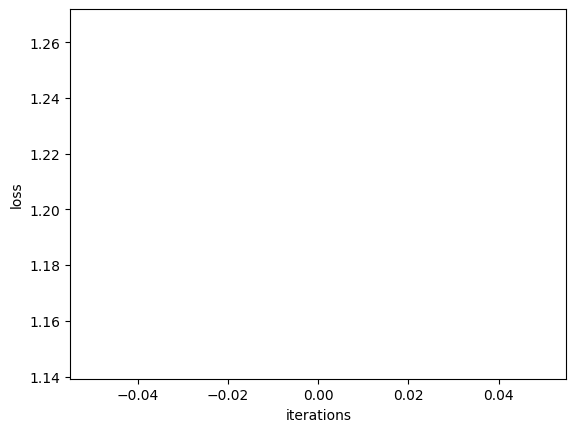

In [33]:
print(loss)

plt.plot(loss.cpu().detach().numpy())

# Adding labels and title
plt.xlabel('iterations')
plt.ylabel('loss')

# Display the plot
plt.show()

100%|██████████| 193/193 [00:09<00:00, 20.62batch/s]
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      1895
           1       0.00      0.00      0.00      1192

    accuracy                           0.61      3087
   macro avg       0.31      0.50      0.38      3087
weighted avg       0.38      0.61      0.47      3087



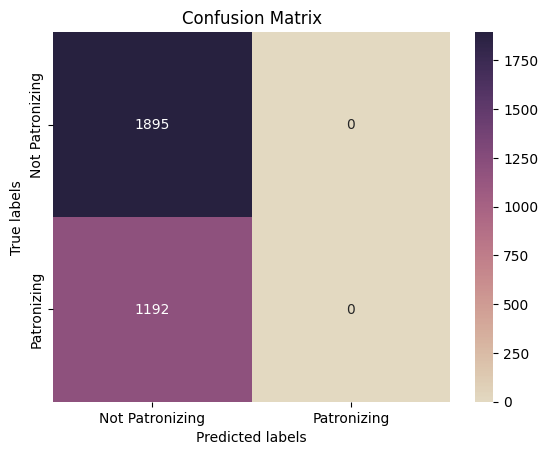

In [ ]:
performance_metrics(model, val_loader)

### Vanilla Model

In [43]:

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=5e-5)

train_model(model, optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1965/1965 [04:49<00:00,  6.80it/s]


100%|██████████| 193/193 [00:09<00:00, 20.56batch/s]

              precision    recall  f1-score   support

           0       0.65      0.99      0.79      1895
           1       0.93      0.15      0.26      1192

    accuracy                           0.67      3087
   macro avg       0.79      0.57      0.53      3087
weighted avg       0.76      0.67      0.58      3087



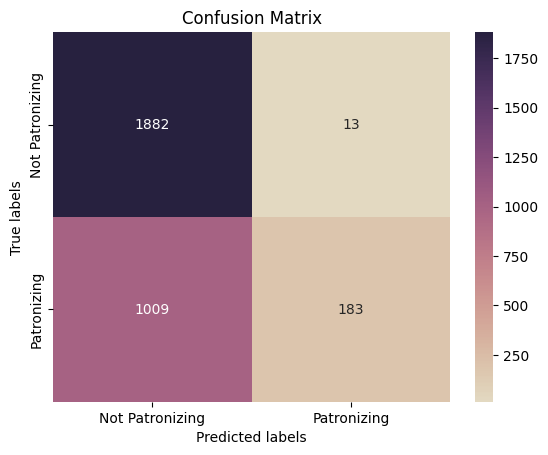

### Some other Model

In [68]:
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=3e-5)

train_model(model, optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


3927


100%|██████████| 3927/3927 [04:57<00:00, 13.19it/s]


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1895
           1       0.66      0.15      0.24       199

    accuracy                           0.91      2094
   macro avg       0.79      0.57      0.60      2094
weighted avg       0.89      0.91      0.89      2094



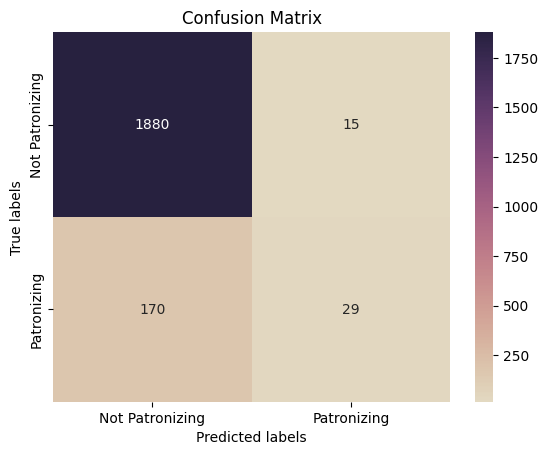

In [69]:
performance_metrics(model, val_loader)

### With Accelerator

In [21]:
from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

accelerator = Accelerator()

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_loader, val_loader, model, optimizer
)

train_model(model, optimizer, train_loader=train_dl, accelerator=accelerator)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


3927


100%|██████████| 3927/3927 [20:17<00:00,  3.23it/s]


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1895
           1       0.00      0.00      0.00       199

    accuracy                           0.90      2094
   macro avg       0.45      0.50      0.48      2094
weighted avg       0.82      0.90      0.86      2094



/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

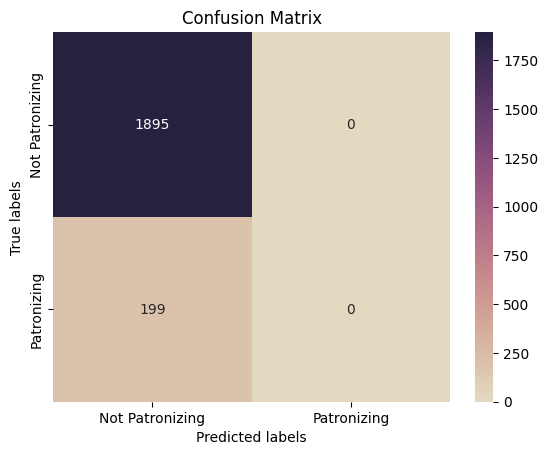

In [22]:
performance_metrics(model, val_loader)

### My custom layer

## Submission Documents

In [ ]:
def get_and_save_predictions(dataset, save_name, model=task1_model):
    y_pred, _ = model.predict(dataset.tolist())
    np.savetxt(f'{save_name}.txt', y_pred, fmt='%d')

# train predictions
get_and_save_predictions(test_data['text'], "test")

# test predictions
get_and_save_predictions(train_data['text'], "dev")

100%|██████████| 105/105 [00:14<00:00,  7.19it/s]
